In [147]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [148]:
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage
from langchain_core.messages import AIMessage, HumanMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]  # 메시지
    next: str  # 다음으로 라우팅할 에이전트

In [149]:
# 1. 메시지 생성
user_message = HumanMessage(content="파이썬으로 웹 스크레이퍼를 만들고 싶어요")
ai_response = AIMessage(content="Researcher 에게 작업을 전달하겠습니다")

# 2. AgentState 객체 생성
agent_state = AgentState(
    messages=[user_message, ai_response],   # 메시지 기록
    next="Researcher"                       # 다음 실행할 에이전트
)

agent_state

{'messages': [HumanMessage(content='파이썬으로 웹 스크레이퍼를 만들고 싶어요', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Researcher 에게 작업을 전달하겠습니다', additional_kwargs={}, response_metadata={})],
 'next': 'Researcher'}

In [150]:
new_message = AIMessage(content="코드를 작성합니다")
agent_state["messages"] += [new_message]
agent_state['next'] = 'Coder'

In [151]:
agent_state

{'messages': [HumanMessage(content='파이썬으로 웹 스크레이퍼를 만들고 싶어요', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Researcher 에게 작업을 전달하겠습니다', additional_kwargs={}, response_metadata={}),
  AIMessage(content='코드를 작성합니다', additional_kwargs={}, response_metadata={})],
 'next': 'Coder'}

In [152]:
def agent_node(state, agent, name):
    print('==' * 50)
    print('===== agent_node() 함수 시작 =====')
    
    print(f"[{name}] 에이전트 호출: ")

    agent_response = agent.invoke(state)                        

    print(agent_response["messages"][-1].content)    
    print('===== agent_node() 함수  끝 =====')
    print('==' * 50)

    # agent의 마지막 메시지를 HumanMessage로 변환하여 반환
    return {
        "messages": [
            HumanMessage(content=agent_response["messages"][-1].content, name=name)
        ]
    }

In [153]:
import functools
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_experimental.tools import PythonREPLTool


tavily_tool = TavilySearch(max_results=1)

python_repl_tool = PythonREPLTool()


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o', 
    temperature=0
)

# Research Agent 생성
research_agent = create_react_agent(llm, tools=[tavily_tool])

# research node 생성
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [154]:
result1 = research_node(
    {
        "messages": [
            HumanMessage(content="1+2의 결과를 출력하는 파이썬 코드를 작성해줘.")
        ]
    }
)

===== agent_node() 함수 시작 =====
[Researcher] 에이전트 호출: 
```python
# 1과 2를 더한 결과를 출력합니다.
result = 1 + 2
print(result)
```

이 코드는 1과 2를 더한 결과인 3을 출력합니다.
===== agent_node() 함수  끝 =====


In [155]:
print(result1)

{'messages': [HumanMessage(content='```python\n# 1과 2를 더한 결과를 출력합니다.\nresult = 1 + 2\nprint(result)\n```\n\n이 코드는 1과 2를 더한 결과인 3을 출력합니다.', additional_kwargs={}, response_metadata={}, name='Researcher')]}


In [156]:
code_system_prompt = """
Be sure to use the following font in your code for visualization.

##### 폰트 설정 #####
import platform

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

##### 마이너스 폰트 깨짐 방지 #####
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 폰트 깨짐 방지
"""


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o', 
    temperature=0
)


# Coder Agent 생성
coder_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    state_modifier=code_system_prompt,
)

coder_node = functools.partial(agent_node, agent=coder_agent, name="Coder")

===== agent_node() 함수 시작 =====
[Coder] 에이전트 호출: 


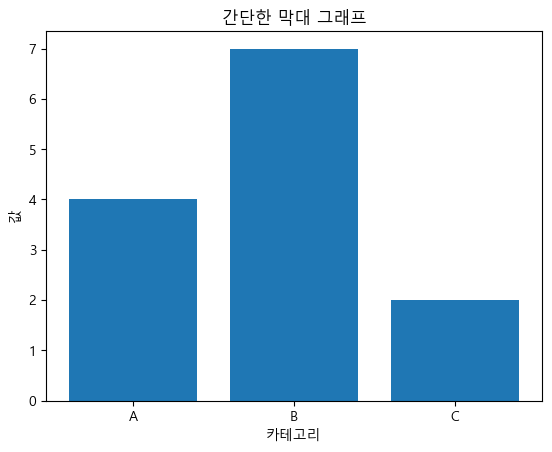

위의 코드를 실행하여 간단한 막대 그래프를 생성했습니다. x축은 ['A', 'B', 'C']이고, y축은 [4, 7, 2]입니다. 그래프는 '간단한 막대 그래프'라는 제목과 함께 표시됩니다.
===== agent_node() 함수  끝 =====


In [157]:
result2 = coder_node(
    {
        "messages": [
            HumanMessage(content="파이썬으로 간단한 막대 그래프를 그려주세요. x축은 ['A', 'B', 'C'], y축은 [4, 7, 2]입니다.")
        ]
    }
)

In [158]:
result2

{'messages': [HumanMessage(content="위의 코드를 실행하여 간단한 막대 그래프를 생성했습니다. x축은 ['A', 'B', 'C']이고, y축은 [4, 7, 2]입니다. 그래프는 '간단한 막대 그래프'라는 제목과 함께 표시됩니다.", additional_kwargs={}, response_metadata={}, name='Coder')]}

In [159]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from pydantic import BaseModel
from typing import Literal


members = ["Researcher", "Coder"]                       # 멤버 Agent 목록 정의

options_for_next = ["FINISH"] + members                 # 다음 작업자 선택 옵션 목록 정의

class RouteResponse(BaseModel):                         # 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
    next: Literal["FINISH", "Researcher", "Coder"]


# 시스템 프롬프트 정의: 작업자 간의 대화를 관리하는 감독자 역할
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# ChatPromptTemplate 생성
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options_for_next), members=", ".join(members))


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o', 
    temperature=0
)

In [160]:
# Supervisor Agent 생성
def supervisor_agent(state):
    print('===== supervisor_agent() 함수 시작 =====')
    
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)           # 프롬프트와 LLM을 결합하여 체인 구성
    
    print('===== supervisor_chain 체인 실행 =====')
    answer = supervisor_chain.invoke(state)
    print(answer)

    print('===== supervisor_agent() 함수  끝 =====')

    return answer                                       # Agent 호출

In [161]:
# 테스트용 초기 상태 생성
initial_state = {
    "messages": [
        {"role": "user", "content": "파이썬으로 웹 스크래핑 프로그램을 만들고 싶습니다."},
        {"role": "assistant", "content": "네, 웹 스크래핑 프로그램 개발에 대한 요청을 받았습니다. 이 작업은 코딩 skills이 필요합니다."},
        {"role": "user", "content": "좋습니다. 어떻게 진행하면 될까요?"}
    ]
}

# supervisor_agent 함수 실행
result2 = supervisor_agent(initial_state)

# 결과 출력
print("\n=== 최종 결과 ===")
print(f"다음 단계 수행자: {result2.next}")

# 결과에 따른 추가 처리
if result2.next == "FINISH":
    print("모든 작업이 완료되었습니다.")
elif result2.next == "Coder":
    print("Coder에게 작업을 전달합니다.")
elif result2.next == "Researcher":
    print("Researcher에게 작업을 전달합니다.")
else:
    print("알 수 없는 응답입니다.")

===== supervisor_agent() 함수 시작 =====
===== supervisor_chain 체인 실행 =====
next='Researcher'
===== supervisor_agent() 함수  끝 =====

=== 최종 결과 ===
다음 단계 수행자: Researcher
Researcher에게 작업을 전달합니다.


In [162]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(AgentState)

# 그래프에 노드 추가
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", coder_node)
workflow.add_node("Supervisor", supervisor_agent)


# 멤버 노드 > Supervisor 노드로 엣지 추가
for member in members:
    workflow.add_edge(member, "Supervisor")

# 조건부 엣지 추가 (
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END


def get_next(state):
    return state["next"]


# Supervisor 노드에서 조건부 엣지 추가
workflow.add_conditional_edges("Supervisor", get_next, conditional_map)

# 시작점
workflow.add_edge(START, "Supervisor")

# 그래프 컴파일
graph = workflow.compile(checkpointer=MemorySaver())

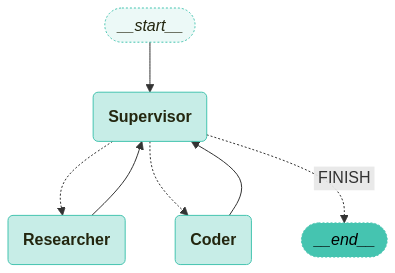

In [163]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

===== supervisor_agent() 함수 시작 =====
===== supervisor_chain 체인 실행 =====
next='Researcher'
===== supervisor_agent() 함수  끝 =====

🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
Researcher
===== agent_node() 함수 시작 =====
[Researcher] 에이전트 호출: 

🔄 Node: agent in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_ntcAmAJ2DtUVw0HSqi85UpKF)
 Call ID: call_ntcAmAJ2DtUVw0HSqi85UpKF
  Args:
    query: 2024 South Korea GDP per capita forecast

🔄 Node: tools in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "South Korea GDP per capita 2024 - StatisticsTimes.com", "url": "https://statisticstimes.com/economy/country/south-korea-gdp-per-capita.php", "content": "GDP per capita of South Korea According to th

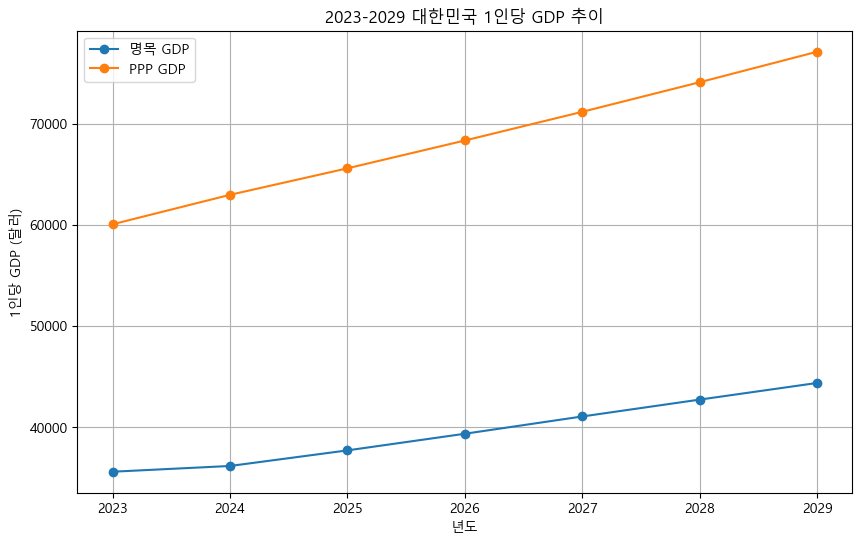


🔄 Node: tools in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: Python_REPL



==================================================위의 데이터를 바탕으로 2023년부터 2029년까지 대한민국의 1인당 GDP 추이를 그래프로 시각화했습니다. 그래프는 명목 GDP와 구매력 평가(PPP) 기준 GDP를 각각 표시하며, 두 지표 모두 지속적으로 증가하는 추세를 보여줍니다. 

이 그래프를 통해 대한민국의 경제 성장 전망을 시각적으로 확인할 수 있습니다.
===== agent_node() 함수  끝 =====

🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

위의 데이터를 바탕으로 2023년부터 2029년까지 대한민국의 1인당 GDP 추이를 그래프로 시각화했습니다. 그래프는 명목 GDP와 구매력 평가(PPP) 기준 GDP를 각각 표시하며, 두 지표 모두 지속적으로 증가하는 추세를 보여줍니다. 

이 그래프를 통해 대한민국의 경제 성장 전망을 시각적으로 확인할 수 있습니다.

🔄 Node: Coder 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: Coder

위의 데이터를 바탕으로 2023년부터 2029년까지 대한민국의 1인당 GDP 추이를 그래프로 시각화했습

In [164]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="2024년의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요."
        )
    ],
}

# 그래프 실행
invoke_graph(graph, inputs, config)